In [4]:
'''
MATH590 Final Project
Brooks Townsend

Image classification, set clustering of cells infected with Malaria

Sources are cited at the bottom of this notebook.

My goal is to use set clustering techniques, similar to those used in C2
to classify an image as parasitized or uninfected (with malaria).

I was able to come up with my own optimal threshold for masking these
images with/without parasitesin about four hours of work, and I decided
to extend this project by attempting to use a neural network
to further improve my classification accuracy.
'''

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
parasitesDir = "./cell_images/training_set/Parasitized/"
uninfectedDir = "./cell_images/training_set/Uninfected/"
pfiles = os.listdir(parasitesDir)
ufiles = os.listdir(uninfectedDir)
parasites = []
uninfected = []

for i in range(len(pfiles)):
    pfiles[i] = parasitesDir + pfiles[i]
    
for i in range(len(ufiles)):
    ufiles[i] = uninfectedDir + ufiles[i]

# There's 13780 files in these directories, and that's far too many
# to have open at one time.
# I will work with the first 100-1000 in this notebook.
for i in range(100):
    parasites.append(Image.open(pfiles[i]))

for i in range(100):
    uninfected.append(Image.open(ufiles[i]))

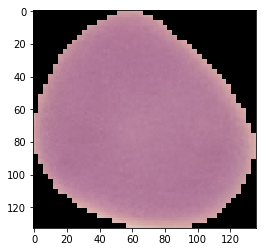

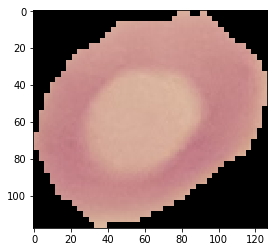

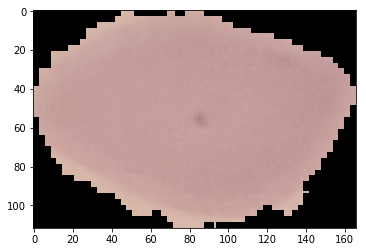

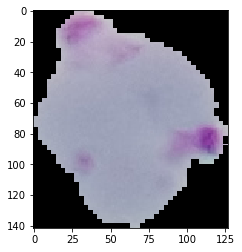

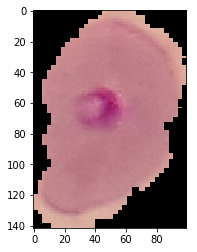

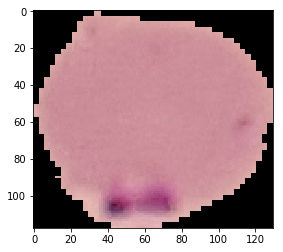

In [3]:
# Examine a few images
import random
plt.figure()
plt.imshow(uninfected[random.randint(0,len(uninfected)-1)])
plt.show()
plt.imshow(uninfected[random.randint(0,len(uninfected)-1)])
plt.show()
plt.imshow(uninfected[random.randint(0,len(uninfected)-1)])
plt.show()
plt.imshow(parasites[random.randint(0,len(parasites)-1)])
plt.show()
plt.imshow(parasites[random.randint(0,len(parasites)-1)])
plt.show()
plt.imshow(parasites[random.randint(0,len(parasites)-1)])
plt.show()
plt.close()

In [4]:
# We'll start calculations using just one parasitic image.
# Pick a lucky number.
luckynumber = random.randint(0, len(pfiles))
luckynumber

9921

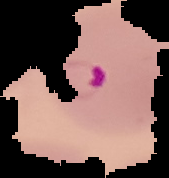

In [5]:
pim = Image.open(pfiles[luckynumber])
pim

In [6]:
red, green, blue = pim.split()

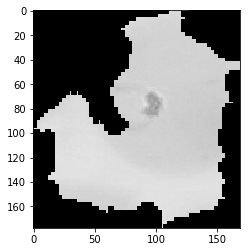

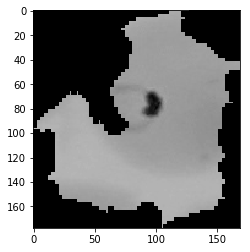

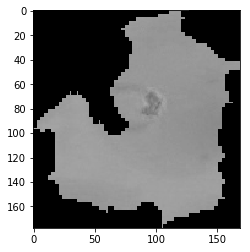

In [7]:
plt.figure(figsize=(4, 4))
plt.imshow(red, cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(green, cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(blue, cmap='gray', vmin=0, vmax=255)
plt.show()
plt.close()

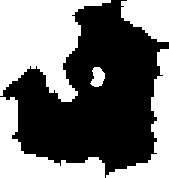

In [8]:
# The green channel appears to best describe the location of the parasites
# Use NP to binarize the image based on intensity.
binarize = np.array(green)
threshold = 100
for i in range(len(binarize)):
    for j in range(len(binarize[0])):
        if binarize[i][j] < threshold:
            binarize[i][j] = 255
        else:
            binarize[i][j] = 0
greenMask = Image.fromarray(binarize)
greenMask

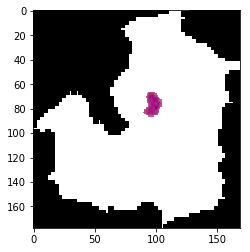

Parasite pixels: 211


In [9]:
isolate = pim.copy()
isolate.putalpha(greenMask)
isolate
plt.figure()
plt.imshow(isolate)
plt.show()
# We've now isolated the parasite in the cell, denoted by color.
isolateArr = np.array(isolate)
totalPixelCount = 0
theoreticalParasiteCount = 0;
for i in range(len(isolateArr)):
    for j in range(len(isolateArr[0])):
        totalPixelCount+=1
        pix = isolateArr[i][j]
        # Full intensity, with color (aka not white or black)
        if pix[3] == 255 and (pix[0] != 0 or pix[1] != 0 or pix[2] != 0):
            theoreticalParasiteCount+=1;
print("Parasite pixels: {}".format(theoreticalParasiteCount))

In [10]:
ratio = theoreticalParasiteCount/totalPixelCount
ratio

0.007014161292467256

In [11]:
# We now can define a function to determine the ratio of parasite pixels
# to total image size. I'll call this the parasite ratio

def parasite_ratio(filename, threshold):
    pim = Image.open(filename)
    r, g, b = pim.split()
    binarize = np.array(g)
    for i in range(len(binarize)):
        for j in range(len(binarize[0])):
            if binarize[i][j] < threshold:
                binarize[i][j] = 255
            else:
                binarize[i][j] = 0
    greenMask = Image.fromarray(binarize)
    pim.putalpha(greenMask)
    iso = np.array(pim)
    pim.close()
    totalCount = 0
    pCount = 0;
    for i in range(len(iso)):
        for j in range(len(iso[0])):
            totalCount+=1
            p = iso[i][j]
            if p[3] == 255 and (p[0] != 0 or p[1] != 0 or p[2] != 0):
                pCount+=1
    return pCount / totalCount

In [12]:
def parasite_ratios(threshold, amt, is_parasitic):
    ratios = []
    zeros = 0
    for i in range(amt):
        ratio = -1
        if is_parasitic:
            ratio = parasite_ratio(pfiles[i], threshold)
        else:
            ratio = parasite_ratio(ufiles[i], threshold)
            
        if ratio == 0:
            zeros += 1
        else:
            ratios.append(ratio)
    return ratios, zeros

def plot_parasite_ratios(threshold, amt, is_parasitic):
    ratios, zeros = parasite_ratios(threshold, amt, is_parasitic)
    plt.figure(figsize=(15, 5))
    plt.xlabel('Parasite Ratio')
    plt.ylabel('# of images')
    plt.title('Parasite ratios')
    histo = plt.hist(ratios, bins="auto", color='red')
    plt.show()
    if is_parasitic:
        print("False negatives: {}".format(zeros))
        print("True Positives: {}".format(amt - zeros))
    else:
        print("True negatives: {}".format(zeros))
        print("False positives: {}".format(amt - zeros))

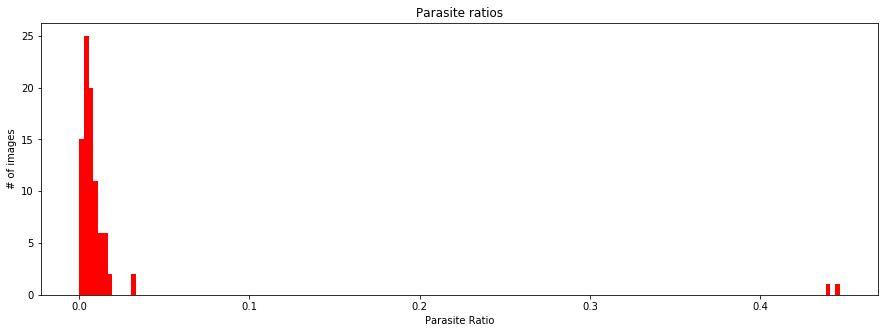

False negatives: 11
True Positives: 89


In [13]:
plot_parasite_ratios(75, 100, True)

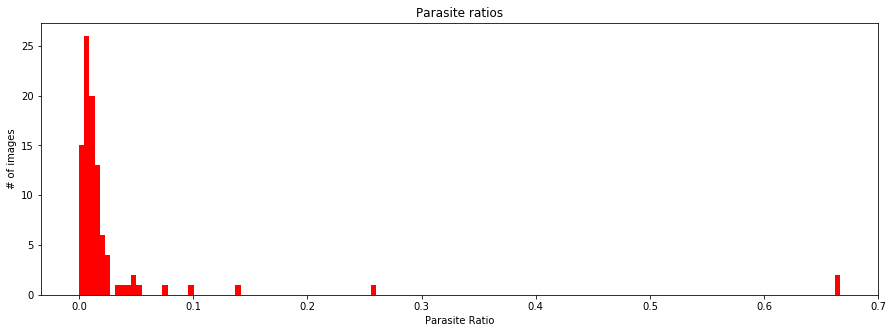

False negatives: 4
True Positives: 96


In [14]:
''' 
It's important to note that in the above image, the far left bar is 
the # of false negatives we have or in other words images that do not
contain parasites at all. We can try to help this number by increasing
the threshold that we allow a parasite to be classified as.
'''
plot_parasite_ratios(100, 100, True)

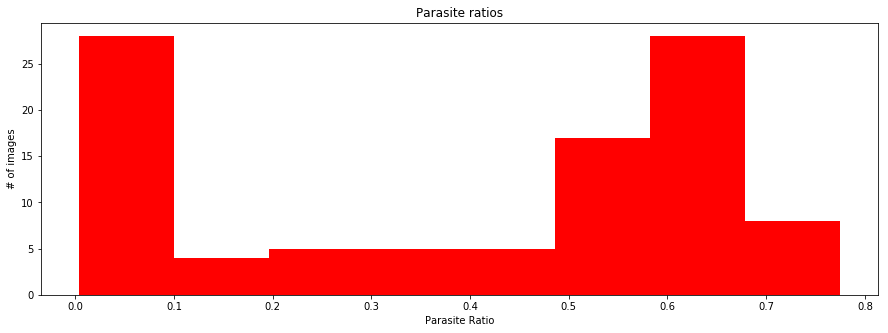

False negatives: 0
True Positives: 100


In [15]:
'''
The easiest solution to too many false negatives is to
increase the threshold to reduce that number to zero.
The problem with this is, we will have trouble with truly detecting
if an image does not have parasites.
'''
plot_parasite_ratios(150, 100, True)

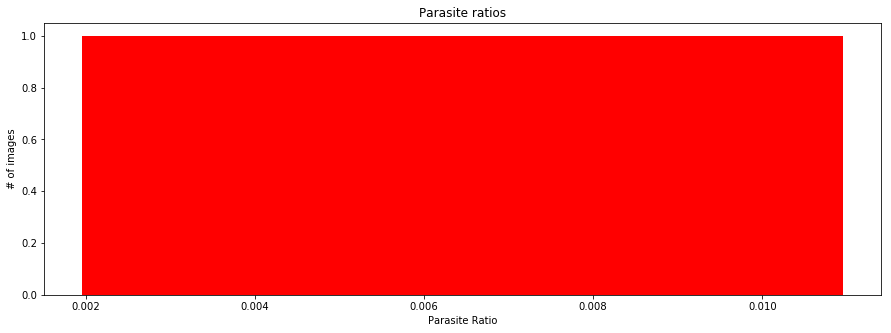

True negatives: 98
False positives: 2


In [16]:
'''
Let's examine our uninfected images to see how our method detects true negatives.
Let's reset our threshold back to our baseline, 75. 
Set is_parasitic to False to deal with uninfected cells.
'''

plot_parasite_ratios(75, 100, False)

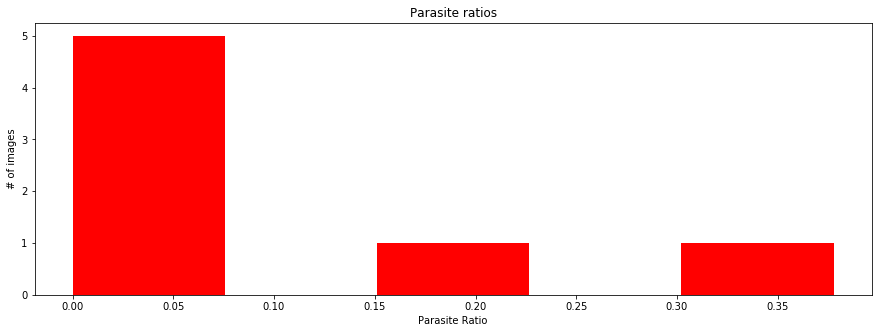

True negatives: 93
False positives: 7


In [17]:
# And at 100
plot_parasite_ratios(100, 100, False)

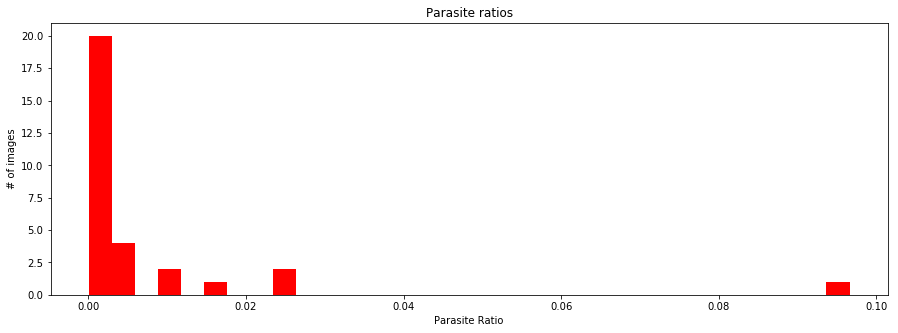

True negatives: 970
False positives: 30


In [18]:
# Let's try a few more to check out our ratio, 75 seemed to be a better threshold.
plot_parasite_ratios(75, 1000, False)

In [19]:
def find_best_ratio(sample_size):
    floor = 75
    ceiling = 125
    all_parasitic = []
    p_zeros = []
    all_uninfected = []
    u_zeros = []
    for i in range(floor, ceiling):
        p, z_p = parasite_ratios(i, sample_size, True)
        u, z_u = parasite_ratios(i, sample_size, False)
        #all_parasitic.append(p)
        p_zeros.append(z_p)
        #all_uninfected.append(u)
        u_zeros.append(sample_size - z_u)
        
    thresh = list(range(floor, ceiling))
    
    plt.figure()
    plt.xlabel("Threshold")
    plt.ylabel("Incorrect predictions")
    plt.scatter(thresh, p_zeros, c="red")
    plt.scatter(thresh, u_zeros, c="green")
    plt.show()
    plt.close()


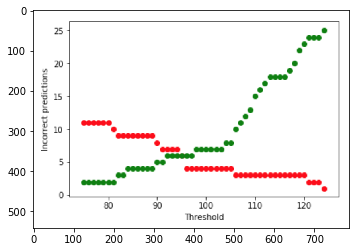

In [20]:
''' 
For 100 samples, plot the number of incorrect predictions
(false positives are reds, false negatives are green)
This takes about 30 minutes to run, feel free to comment it out in the execution.
I'll just show the output instead since we don't use
the result in the following analysis.
'''

# find_best_ratio(100)
plt.figure()
plt.imshow(Image.open('output/graph.png'))
plt.show()
plt.close()

'''
Conclusions: The best mix of ratio seems to be around the 90-100 range
- A threshold of about 95 seems to be the best balance to classify cells,
with about a 6% error rate
- A threshold of over 120 results in the best to classify parasitic
cells (most likely oversensitive)
- A threshold of below 80 is best for uninfected, however this is
most likely not sensitive enough
'''

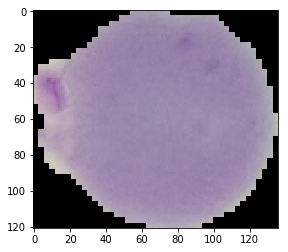

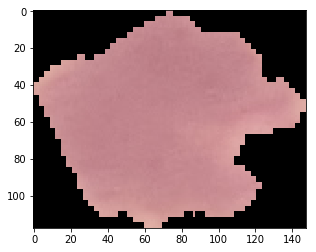

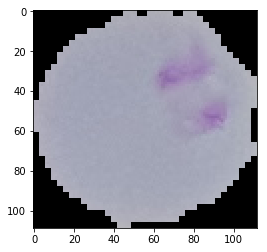

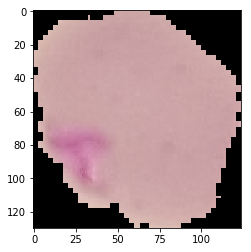

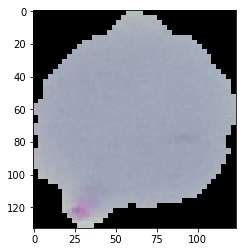

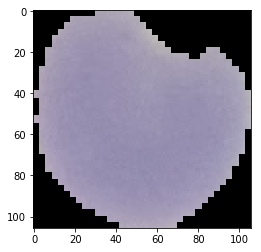

In [21]:
# So we've figured out that our manual clustering by parasite ratios works for most 
# images. But why not all?
# I wanted to take a look at some of the images that I classified incorrectly.
pics = []
for i in range(100):
    r = parasite_ratio(pfiles[i], 95)
    if r == 0.0:
        pics.append(i)
plt.figure()
for p in pics:
    im = Image.open(pfiles[p])
    plt.imshow(im)
    plt.show()
    im.close()
plt.close()

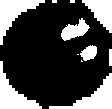

In [22]:
''' 
Before we could classify a cell infected with Malaria when it
had an anomaly in the green color spectrum. The heuristic works about
95% of the time with a threshold of 95.I wanted to check out a few of
them that look like we could have distinguished them
'''
threshold = 150
im = Image.open(pfiles[pics[2]])
red, green, blue = im.split()
r = parasite_ratio(pfiles[pics[2]], threshold)
binarize = np.array(green)
for i in range(len(binarize)):
    for j in range(len(binarize[0])):
        if binarize[i][j] < threshold:
            binarize[i][j] = 255
        else:
            binarize[i][j] = 0
greenMask = Image.fromarray(binarize)
greenMask
'''
Looks like in this case a higher threshold would have helped us. 
However the higher the threshold, the worse
our predictions get in the uninfected case.
'''

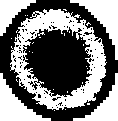

In [23]:
threshold = 150
im = Image.open(ufiles[pics[2]])
red, green, blue = im.split()
r = parasite_ratio(ufiles[pics[2]], threshold)
binarize = np.array(green)
for i in range(len(binarize)):
    for j in range(len(binarize[0])):
        if binarize[i][j] < threshold:
            binarize[i][j] = 255
        else:
            binarize[i][j] = 0
greenMask = Image.fromarray(binarize)
greenMask

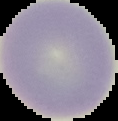

In [24]:
im

In [25]:
# This is an uninfected image we would have said had a VERY high parasite ratio.

In [26]:
'''
Manual classification has worked fine up until this point, but it's
not perfect. I hypothesize that the use of a neural network that is
made to classify images could be more accurate due to its ability to classify
an image on more than just a green layer mask.

I have some experience using machine learning to do image
classification (see the number classification problem, I completed it through a
coursera machine learning course) but I used a source to help me get through the
initial learning curve of the keras library, and training a sequential neural network.
(see sources at the bottom)

The source uses this neural network to classify images of cats and dogs, I 
will use it to classify a cell as parasitic or uninfected.
''';

In [5]:
# Importing the Keras libraries and packages
from keras.models import Sequential, load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

# Part 2 - Fitting the CNN to the images
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('cell_images/training_set',
                                                target_size = (64, 64),
                                                batch_size = 32,
                                                class_mode = 'binary')
test_set = test_datagen.flow_from_directory('cell_images/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 27358 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


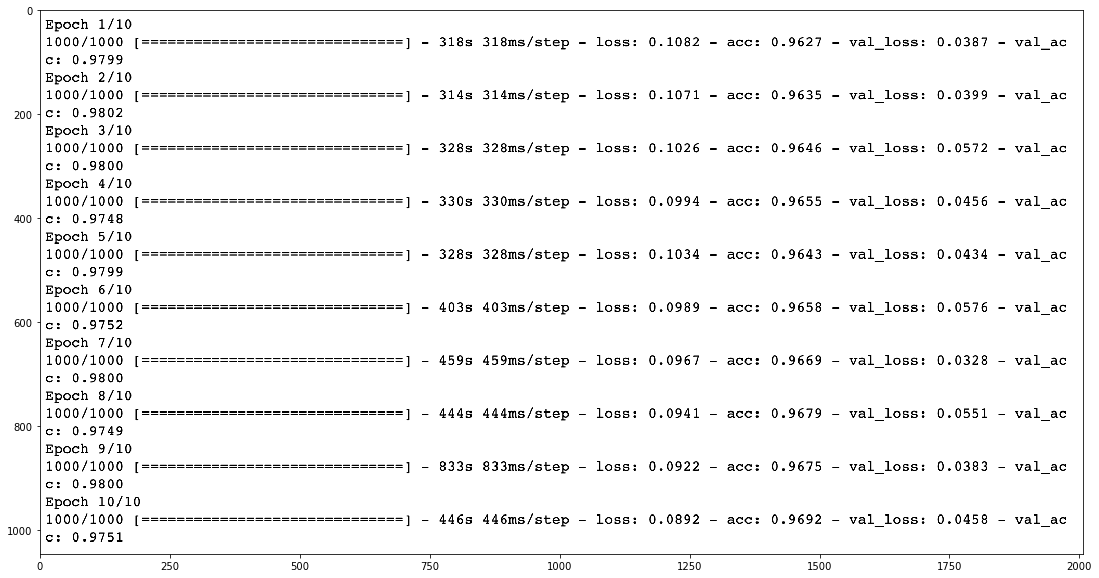

In [6]:
classifier = load_model('malaria_model.h5')

# This is commented out due to the sheer amount of time it takes to compile the neural net
# Training the neural net on 1000 images, 10 generations and validating
# with a test set of 250 images.

# classifier.fit_generator(training_set,
# steps_per_epoch = 1000,
# epochs = 10,
# validation_data = test_set,
# validation_steps = 250)

# Saving because the above step took about an hour to run.
# classifier.save('malaria_model.h5')

# Output of calling fit_generator:
plt.figure(figsize=(20, 10))
plt.imshow(Image.open('output/classifier.png'))
plt.show()
plt.close()

In [7]:
# Part 3 - Making new predictions

In [8]:
test_image = image.load_img('cell_images/single_prediction/single_parasite.png'
                            , target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'uninfected'
else:
    prediction = 'parasitic'
prediction

'parasitic'

In [9]:
test_image = image.load_img('cell_images/single_prediction/single_uninfected.png'
                            , target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'uninfected'
else:
    prediction = 'parasitic'
prediction

'uninfected'

In [12]:
'''
The model can correctly classify cells with an accuracy rate of about 97.5%.
Its better than the green mask by about 3.5% in terms of partitioning the 
images into the correct set.
''';

In [13]:
'''
Sources:
- Malaria images: 
https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria
- Image classification with Neural Network: 
https://becominghuman.ai/building-an-image-classifier-using-deep-learning-in-python-totally-from-a-beginners-perspective-be8dbaf22dd8
''';